# LeNet-5 in PyTorch

The goal of this notebook is to have a LeNet-5 architecture for:
- RGB image datasets
- Optional number of output classes

Afterward, we will train this model for 2 datasets
- The `CIFAR10` dataset (10 classes)
- The custom dataset `02_forest_fire_dataset` (2 classes)


## Directory Structure

It's assumed the directory structure is as follows

``` bash
.
├── data/
│   └── 02_forest_fire_dataset
│       ├── testing/
│       └── training/
│
├── jupyter_notebooks/
│
└── src/
    ├── data/
    ├── models/
    └── visualization/
```

## Import Libraries

In [1]:
import numpy as np
from datetime import datetime 

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torchvision import datasets, transforms

import matplotlib.pyplot as plt

## Import Custom Modules

In [2]:
import sys 
sys.path

['/Users/rodrigo/anaconda3/envs/pytorch_env/lib/python312.zip',
 '/Users/rodrigo/anaconda3/envs/pytorch_env/lib/python3.12',
 '/Users/rodrigo/anaconda3/envs/pytorch_env/lib/python3.12/lib-dynload',
 '',
 '/Users/rodrigo/anaconda3/envs/pytorch_env/lib/python3.12/site-packages']

In [3]:
sys.path.append('..')

In [4]:
from src.data.dataset_properties import dataset_stat_prop

In [5]:
help(dataset_stat_prop)

Help on function dataset_stat_prop in module src.data.dataset_properties:

dataset_stat_prop(dataset)
    Function to calculate the statistical properties of a custom dataset.
    The intent is to use the calculated mean and std as an input to
    `torchvision.transforms.Normalize()` prior to training a model

    Parameters
    ----------
    dataset : object
        Pytorch dataset object. Note that the images contained in the dataset
        should be in the [0,1] interval.

    Returns
    -------
    Tuple
        mean and standard deviation of all images in dataset.



In [6]:
from src.visualization.plot_images import display_image_batch

### Additional Parameters

In [7]:
# To improve the rendering of figures
%config InlineBackend.figure_format = 'retina'

In [8]:
# Get CPU, GPU, or MPS device for training
# Note the MPS device is only available to MAC computers using M1/M2 chips

DEVICE = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {DEVICE} device")

Using mps device


For this notebook we won't get into implementing the `.to(device)`, so we'll only use our CPU

# Implementing LeNet-5

We now define a model `LeNet5` for classification of an arbitrary number of classes.
Note it also implements the following methods:
- `forward` that returns all the logits (batch size x Nclasses)
- `predict` that returns the hard predictions for the classifier (batch size)
- `predict_proba` that returns the soft predictions for the classifier (batch size x Nclases)

In [9]:
import torch
import torch.nn as nn

class LeNet5(nn.Module):
    '''
    LeNet-5 Image classifier for images sized [3,32,32] and arbitrary number of classes.
    
    Note the activation functions have been modified to ReLU Pooling Layers are MaxPool
    
    '''
    def __init__(self, n_classes):
        """Constructor for LeNet5 class
        
        Parameters
        ----------
        n_classes : Integer
            Number of classes for the classification task. It has to be at least 2.
        """

        assert isinstance(n_classes,int),'n_classes must be an integer'
        assert (n_classes>=2),'n_classes must be an integer >= 2'

        super(LeNet5, self).__init__()
        
        self.convolutional_layers = nn.Sequential(            
            # First Convolution
            # Input Image size 3 x 32 x 32
            # Output is 6 x 28 x 28
            nn.Conv2d(in_channels = 3, out_channels = 6, kernel_size = 5, stride = 1),
            nn.ReLU(),

            # Pool
            # Input is 6 x 28 x 28
            # Output is 6 x 14 x 14
            nn.MaxPool2d(kernel_size = 2, stride = 2),
            
            # Second Convolution
            # Input Image size 6 x 14 x 14
            # Output is 16 x 10 x 10
            nn.Conv2d(in_channels = 6, out_channels = 16, kernel_size = 5, stride = 1),
            nn.ReLU(),

            # Second Pool
            # Input is 16 x 10 x 10
            # Output is 16 x 5 x 5
            nn.MaxPool2d(kernel_size = 2,stride = 2),
            
            # Third Convolution
            # Input is 16 x 5 x 5
            # Output is 120 x 1 x 1
            nn.Conv2d(in_channels = 16, out_channels = 120, kernel_size = 5, stride = 1),
            nn.ReLU()
        )

        self.fc_layers = nn.Sequential(
            nn.Linear(in_features = 120, out_features = 84),
            nn.ReLU(),
            nn.Linear(in_features = 84, out_features = n_classes),
        )

    def forward(self, x):
        """Forward pass method for LeNet5 class
        
        Parameters
        ----------
        x : Tensor
            Image tensor of size [batch_size,3,32,32]
        
        Returns
        -------
        Tensor
            Un-normalized logits after forward pass, note that
            the output is a tensor of size [batch_size,n_classes]
        """
        x = self.convolutional_layers(x)
        
        # Make x a one-dimentional tensor of size 120
        x = torch.flatten(x, 1)

        x = self.fc_layers(x)
        
        # Return un-normalized logits
        return x

    def predict(self,x):
        '''Method to get hard class predictions
        
        Parameters
        ----------
        x : Tensor
            Image tensor of size [batch_size,3,32,32]
        
        Returns
        -------
        Tensor
            Tensor with the highest class logit, note the output size
            is a sized [batch_size,1], where each column contains the 
            hard class prediction (integer between 0 and n_classes)

        '''
        predictions = self.forward(x)
        
        # Find highest class logit
        hard_class_predictions = torch.argmax(predictions, dim=1)
        
        return hard_class_predictions

    def predict_proba(self,x):
        """Method to get the soft predictions (probabilities) of each class
        
        Parameters
        ----------
        x : Tensor
            Image tensor of size [batch_size,3,32,32]
        
        Returns
        -------
        Tensor
            Predicted probabilities for each class. The output size
            is [bach_size,n_classes]
        """

        # First get the un-normalized logits
        predictions = self.forward(x)
        
        # Instantiate Softmax along dimension 1
        softmax_layer = nn.Softmax(dim = 1)

        # Calculate probabilities
        predicted_prob = self.softmax_layer(predictions)

        return predicted_prob

# Training on `CIFAR10` Dataset

## Prepare Data

### Load Dataset and obtain Statistics

In [10]:
from torch.utils.data import ConcatDataset
import torch
import torchvision
import torchvision.transforms as transforms

In [11]:
# define the train dataset, in this case images from CIFAR10
train_dataset = torchvision.datasets.CIFAR10(root='./data', train = True,
                                             download = True, transform = transforms.ToTensor())

Files already downloaded and verified


Calculate mean and standard deviation on train dataset

In [12]:
mean,std = dataset_stat_prop(train_dataset)

In [13]:
print('Mean\t',mean)
print('STD\t',std)

Mean	 tensor([0.4914, 0.4822, 0.4465])
STD	 tensor([0.2470, 0.2435, 0.2616])


We'll use these `mean` and `std` values to normalize the dataset before training the model.

### Define Train and Test Data

In [14]:
# Define Transformation

# 1) ToTensor() converts PIL image to tensor in [0,1] interval
# 2) Normalizes according to mean and std calculated previously

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(mean,std)])

In [15]:
transform

Compose(
    ToTensor()
    Normalize(mean=tensor([0.4914, 0.4822, 0.4465]), std=tensor([0.2470, 0.2435, 0.2616]))
)

Note for the batch size we're using the following values to speedup training
- `train_dataset` 4
- `validation_dataset` 1024

In [16]:
train_dataset = torchvision.datasets.CIFAR10(root='./data', train = True,
                                             download = True, transform = transform)

train_dataloader = torch.utils.data.DataLoader(train_dataset,batch_size = 4,                         
                                           shuffle = True, num_workers = 2)

validation_dataset = torchvision.datasets.CIFAR10(root = './data', train = False,
                                             download = True, transform = transform)

validation_dataloader = torch.utils.data.DataLoader(validation_dataset,batch_size = 1024,
                                           shuffle = True, num_workers = 2)

classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


### Plot Images from Sample Batch

Just to double check the images are correctly loaded

In [17]:
display_image_batch?

Signature: display_image_batch(data_loader, n_batches, img_classes)
Docstring:
Function to display a batch of images from a dataloader

Parameters
----------
data_loader : object
    PyTorch dataloader object
n_batches : integer
    Number of batches to display
img_classes : tuple
    Image classes contained in the dataset
File:      ~/Documents/BrainStation/Capstone Project/capstone_project/src/visualization/plot_images.py
Type:      function

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


horse   cat   dog  ship


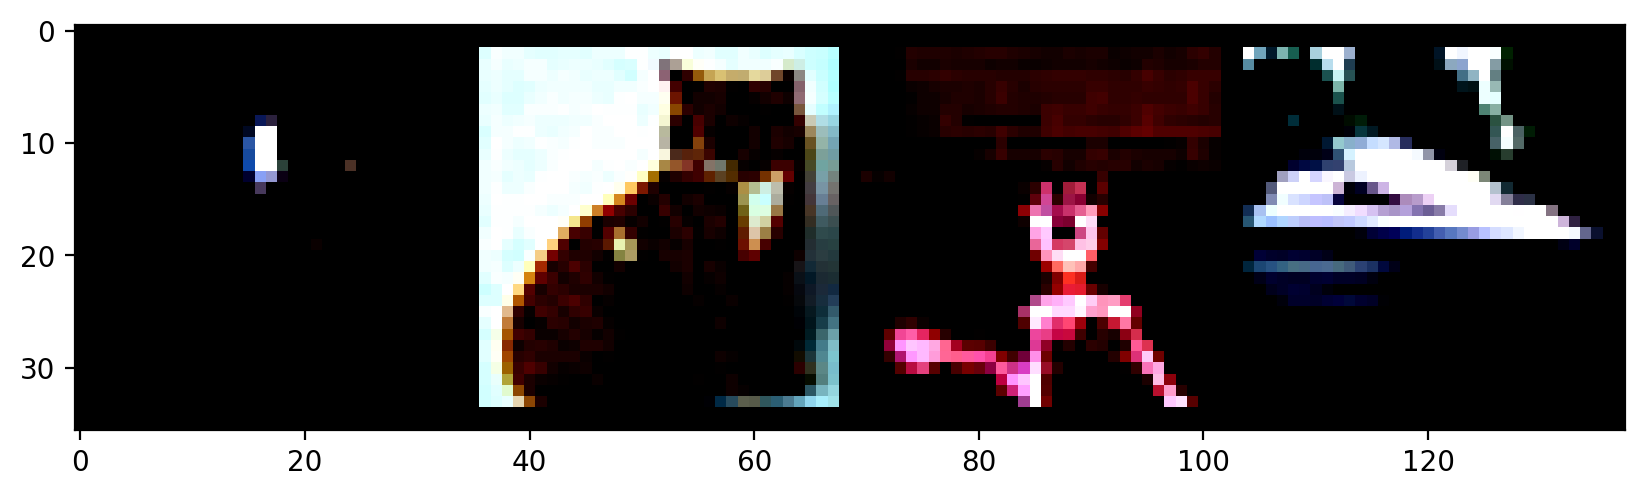

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


  dog   cat   cat  bird


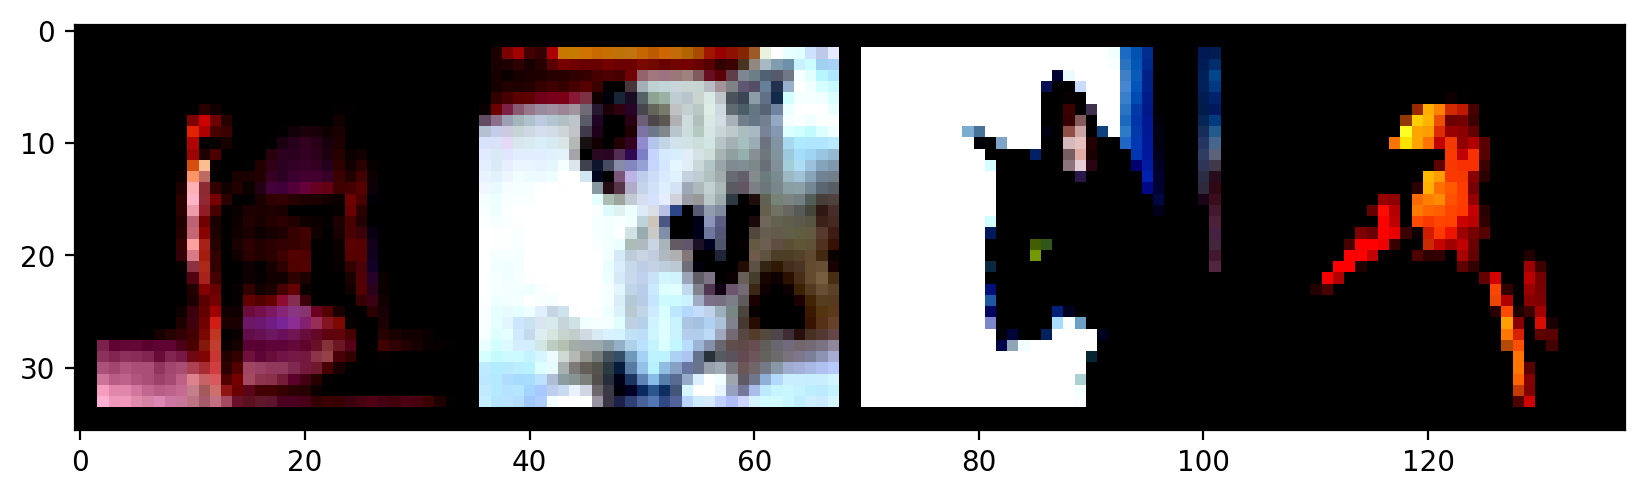

In [18]:
display_image_batch(train_dataloader,2,classes)

## Instantiate Model

In [19]:
# Set manual seed for repeatability
RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)

In [21]:
N_CLASSES = 10

In [22]:
# Instantiate LeNet5, note we're explicitely training it on CIFAR10
# model_cifar10 = LeNet5(N_CLASSES).to(DEVICE)
model_cifar10 = LeNet5(N_CLASSES)

## Define Optimizer and Loss Function

In [23]:
# Use Adam optimizer and cross-entropy loss
optimizer = torch.optim.Adam(model_cifar10.parameters(), lr = 0.001)
loss_function = nn.CrossEntropyLoss()

## Train the Model

First let's define a helper function to calculate validation loss and accuracy

In [24]:
def get_loss_acc(model,loss_func, dataloader):
    '''
    Helper function to get classification accuracy and losses for a model over the items in dataloader.
    
    '''
    
    curr_loss = 0.0
    correct = 0

    # Go through all of the data
    for batch in dataloader:
    
        images, true_labels = batch
        
        # Get the hard prediction
        pred_labels = model.predict(images)
        
        # Get the logits
        pred_logits = model(images)

        # Calculate loss
        loss = loss_func(pred_logits,true_labels)

        # Accumulate current loss
        curr_loss += loss.item()

        # Count number of correct predictions
        correct += (pred_labels == true_labels).sum().item() / true_labels.shape[0]
        
    validation_accuracy = correct / len(dataloader)
    validation_loss = curr_loss / len(dataloader)
    
    return validation_accuracy,validation_loss

In [25]:
N_EPOCHS = 10

In [26]:
train_losses = []
train_accuracy = []

validation_losses = []
validation_accuracy = []

for epoch in range(N_EPOCHS):

    loss_sum = 0.0
    accuracy_sum = 0.0

    # Training loop 
    for batch in train_dataloader:
        
        # Get images and labels from batch
        images, true_labels = batch

        # images = images.to(DEVICE)
        # true_labels = true_labels.to(DEVICE)

        # Forward Pass
        pred_logits = model_cifar10(images)
        
        # Loss Calculation
        loss = loss_function(pred_logits,true_labels)

        # Backward pass and zero gradients
        optimizer.zero_grad()
        loss.backward()
        
        # Update model weights
        optimizer.step()
        
        # Accumulate loss for this batch
        loss_sum += loss.item()

        # Get predicted labels on images
        pred_labels = model_cifar10.predict(images)

        accuracy_sum += (true_labels == pred_labels).sum().item() / true_labels.shape[0]

    average_loss = loss_sum / len(train_dataloader)
    average_accuracy = accuracy_sum / len(train_dataloader)

    # Update training losses and accuracy for this epoch
    train_losses.append(average_loss)
    train_accuracy.append(average_accuracy)

    val_accuracy, val_loss = get_loss_acc(model_cifar10,loss_function,validation_dataloader)  
    
    validation_losses.append(val_loss)
    validation_accuracy.append(val_accuracy)
    
    print(f'{datetime.now().time().replace(microsecond=0)}\t'
          f'Epoch: {epoch}\t'
          f'Train loss: {average_loss:.4f}\t'
          f'Val. loss: {val_loss:.4f}\t'
          f'Train accuracy: {100 * average_accuracy:.2f}\t'
          f'Val. accuracy: {100 * val_accuracy:.2f}')

print('Finished Training') 

16:24:33	Epoch: 0	Train loss: 1.5096	Val. loss: 1.3297	Train accuracy: 47.33	Val. accuracy: 52.44
16:25:09	Epoch: 1	Train loss: 1.2530	Val. loss: 1.1828	Train accuracy: 58.43	Val. accuracy: 58.13
16:25:45	Epoch: 2	Train loss: 1.1575	Val. loss: 1.2101	Train accuracy: 62.20	Val. accuracy: 58.14
16:26:21	Epoch: 3	Train loss: 1.0981	Val. loss: 1.1507	Train accuracy: 64.24	Val. accuracy: 59.65
16:26:55	Epoch: 4	Train loss: 1.0495	Val. loss: 1.1536	Train accuracy: 65.99	Val. accuracy: 60.55
16:27:31	Epoch: 5	Train loss: 1.0165	Val. loss: 1.1740	Train accuracy: 67.18	Val. accuracy: 60.12
16:28:07	Epoch: 6	Train loss: 0.9878	Val. loss: 1.1263	Train accuracy: 68.42	Val. accuracy: 61.87
16:28:42	Epoch: 7	Train loss: 0.9676	Val. loss: 1.1424	Train accuracy: 68.84	Val. accuracy: 61.60
16:29:18	Epoch: 8	Train loss: 0.9466	Val. loss: 1.1330	Train accuracy: 69.62	Val. accuracy: 61.86
16:29:54	Epoch: 9	Train loss: 0.9266	Val. loss: 1.1309	Train accuracy: 70.71	Val. accuracy: 62.37
Finished Training


Maybe save model at this point.

## Model Evaluation

Here we're plotting the losses and accuracies for training and validation, to determine the optimal number of epochs and to address overfitting from the model.

In [27]:
def plot_loss_acc(train_losses, valid_losses,train_acc,valid_acc):
    '''
    Function for plotting training and validation losses
    '''

    train_losses = np.array(train_losses) 
    valid_losses = np.array(valid_losses)

    train_acc = np.array(train_acc)
    valid_acc = np.array(valid_acc)

    N = len(train_losses)
    epochs = np.arange(N)
    

    plt.subplots(1,2,figsize = (14,5))

    # plot losses
    plt.subplot(1,2,1)

    plt.plot(train_losses, color='blue', label='Training Loss') 
    plt.plot(valid_losses, color='red', label='Validation Loss')

    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Over Epochs')
    plt.xticks(ticks = epochs)
    plt.xlim(min(epochs),max(epochs))
    plt.legend()
    plt.grid()

    # plot accuracies
    plt.subplot(1,2,2)

    plt.plot(train_acc, color='blue', label='Training Accuracy') 
    plt.plot(valid_acc, color='red', label='Validation Accuracy')

    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.xticks(ticks = epochs)
    plt.xlim(min(epochs),max(epochs))
    plt.legend()
    plt.grid()
    
    plt.show()

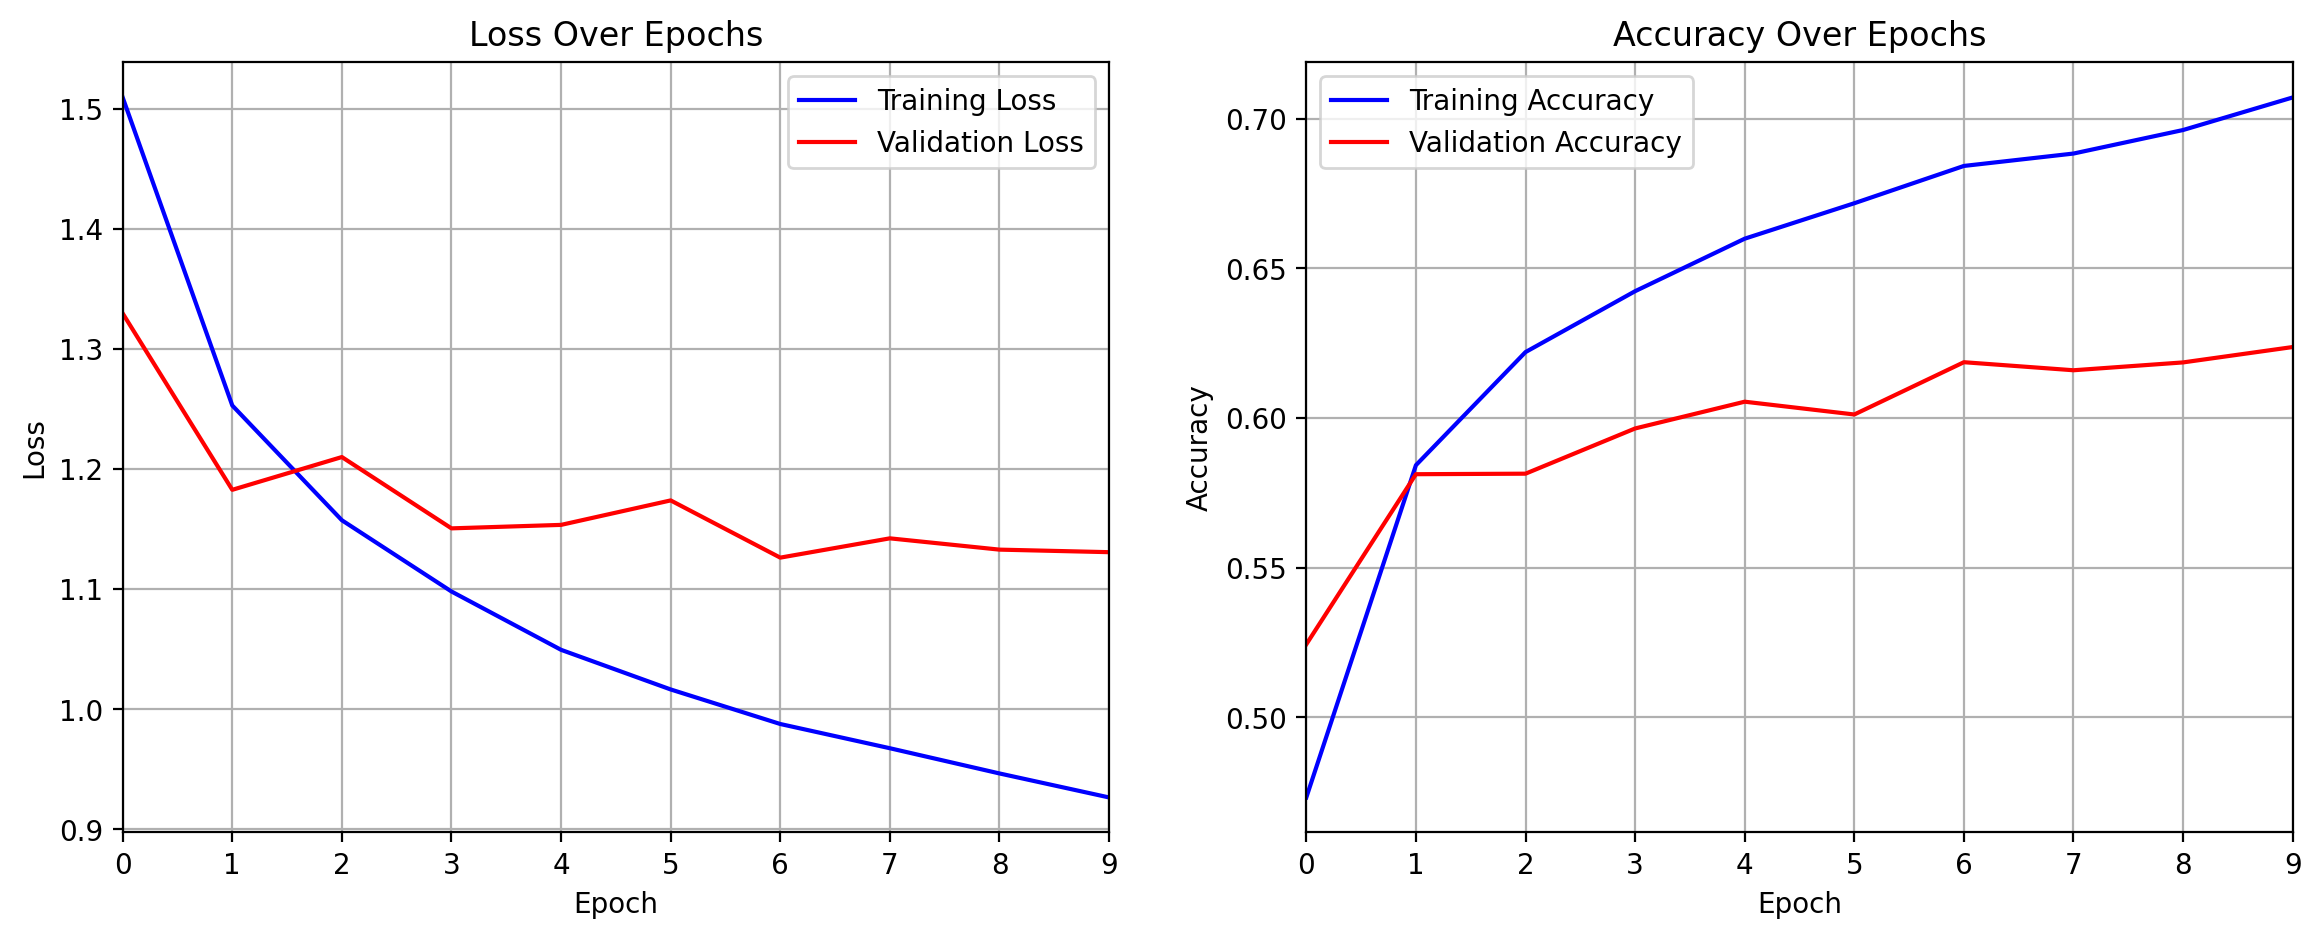

In [28]:
plot_loss_acc(train_losses, validation_losses,train_accuracy,validation_accuracy)

We don't see an obvious increase in the validation loss, rather it seems it plateaus. Perhaps training over more epochs will aid in seeing if the model overfits.

# Training on`02_forest_fire_dataset`

For now, we'll now repeat the same exercise for the `02_forest_fire_dataset`

## Prepare Data

### Define Custom Class and Paths

In [29]:
# Import Custom Dataset Class
from src.data.create_dataset import CustomFireImagesDataset

Define paths to dataset and annotations file

In [30]:
path_to_dataset = '../data_preprocessing/02_forest_fire_dataset/'
annotations_file_test = 'labels_02_test_dataset_prep.csv'
annotations_file_train = 'labels_02_train_dataset_prep.csv'

In [33]:
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.transforms import v2

### Load Dataset and obtain Statistics

First define the transformations to get statistics

In [34]:
# Convert uint8 to float and divide by 255. 
# This is the equivalent of ToTensor() when used on a PIL image

curr_transf = transforms.Compose([transforms.v2.ToDtype(torch.float),
                                  transforms.Normalize(mean = [0,0,0],std = [255,255,255]),
                                  transforms.Resize(size=(32,32))
                                 ])

In [35]:
train_dataset =  CustomFireImagesDataset(annotations_file_train, path_to_dataset,
                                         transform = curr_transf
                                        )

In [36]:
from src.data.dataset_properties import dataset_stat_prop

In [37]:
dataset_stat_prop?

Signature: dataset_stat_prop(dataset)
Docstring:
Function to calculate the statistical properties of a custom dataset.
The intent is to use the calculated mean and std as an input to 
`torchvision.transforms.Normalize()` prior to training a model

Parameters
----------
dataset : object
    Pytorch dataset object. Note that the images contained in the dataset 
    should be in the [0,1] interval.

Returns
-------
Tuple
    mean and standard deviation of all images in dataset. 
File:      ~/Documents/BrainStation/Capstone Project/capstone_project/src/data/dataset_properties.py
Type:      function

In [38]:
mean,std = dataset_stat_prop(train_dataset)

In [39]:
print('Mean\t',mean)
print('STD\t',std)

Mean	 tensor([0.4244, 0.3611, 0.2844])
STD	 tensor([0.2603, 0.2299, 0.2556])


We'll use these values later on to normalize the inputs for training

### Define Train and Test Data

In [40]:
# similar to before, but added an additional normalization
# according to the statistics we calculated

curr_transf = transforms.Compose([transforms.v2.ToDtype(torch.float),
                                  transforms.Normalize([0,0,0],[255,255,255]),
                                  transforms.Resize(size=(32,32)),
                                  transforms.Normalize(mean,std)
                                 ])

In [41]:
# First, create Datasets for Training and Testing
train_dataset =  CustomFireImagesDataset(annotations_file_train, path_to_dataset,
                                         transform = curr_transf
                                        )

test_dataset = CustomFireImagesDataset(annotations_file_test, path_to_dataset,
                                       transform = curr_transf
                                      )

img_classes = ('non-fire','fire')

In [42]:
# Next, create the DataLoaders
# We'll be shuffling both datasets

train_dataloader = DataLoader(train_dataset, batch_size = 8, shuffle = True, num_workers = 2)
test_dataloader = DataLoader(test_dataset, batch_size = 8, shuffle = True, num_workers = 2 )

In [53]:
len(train_dataset)

1631

In [54]:
len(test_dataset)

379

### Plot Images from Sample Batch

In [43]:
from src.visualization.plot_images import display_image_batch

In [44]:
display_image_batch?

Signature: display_image_batch(data_loader, n_batches, img_classes)
Docstring:
Function to display a batch of images from a dataloader

Parameters
----------
data_loader : object
    PyTorch dataloader object
n_batches : integer
    Number of batches to display
img_classes : tuple
    Image classes contained in the dataset
File:      ~/Documents/BrainStation/Capstone Project/capstone_project/src/visualization/plot_images.py
Type:      function

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


non-fire non-fire  fire non-fire  fire  fire non-fire non-fire


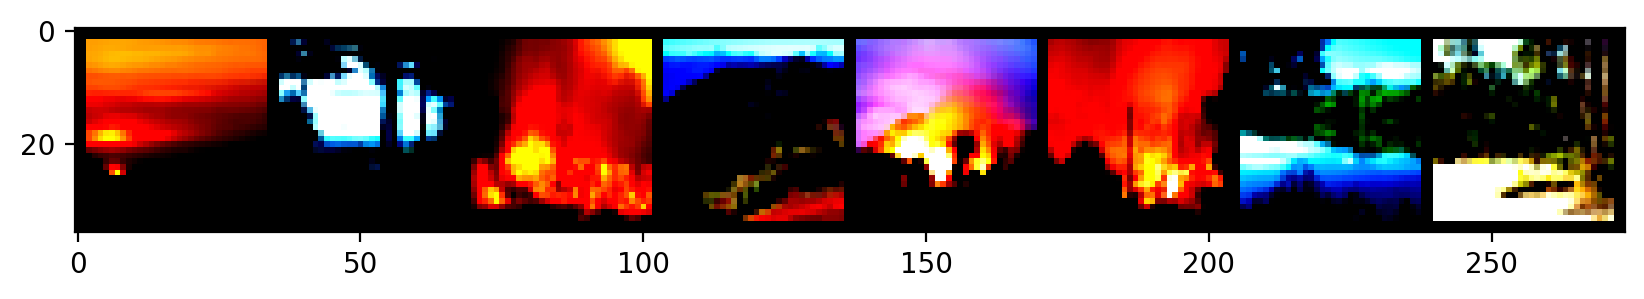

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


non-fire non-fire  fire non-fire  fire  fire  fire non-fire


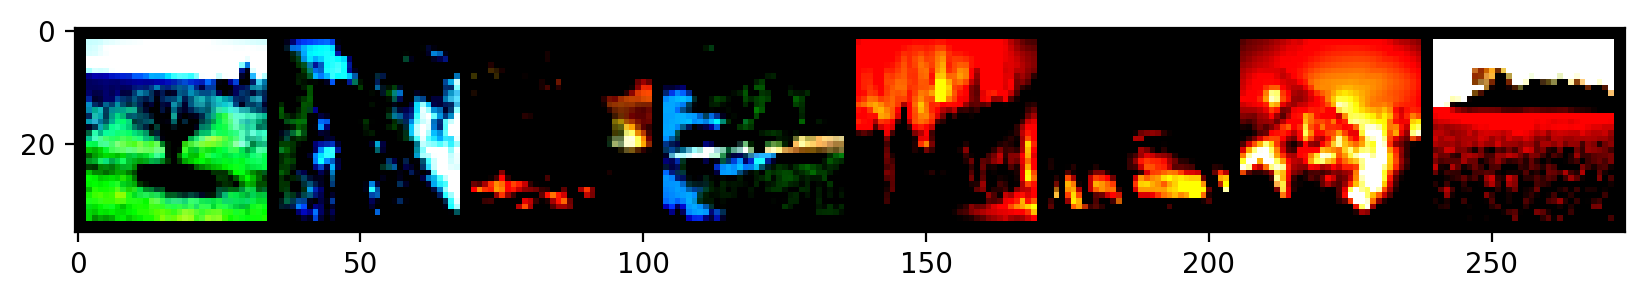

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 fire non-fire non-fire  fire non-fire  fire  fire  fire


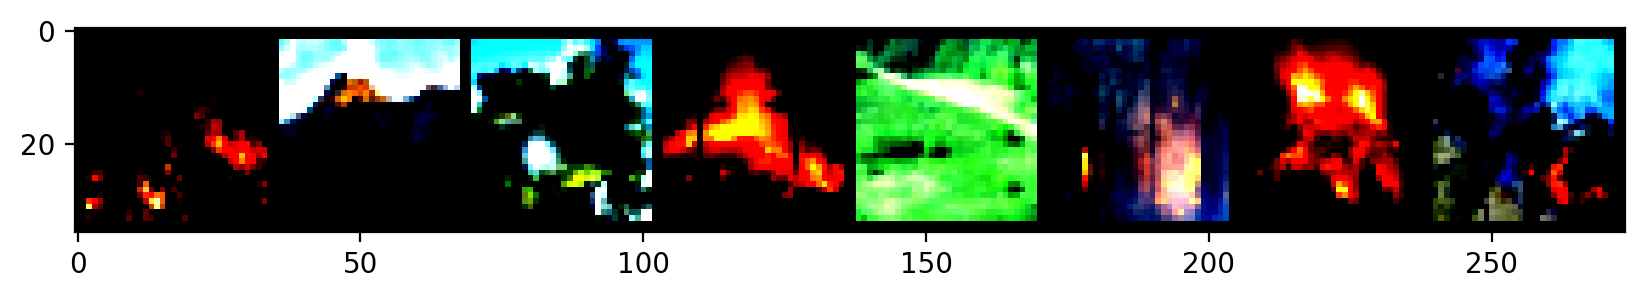

In [45]:
display_image_batch(train_dataloader,3,img_classes)

Looking good so far. We'll proceed to make the actual datasets for train/test

## Instatiante Model

Note there are 2 classes now (non-fire and fire).

In [46]:
N_CLASSES = 2
model_02dataset = LeNet5(N_CLASSES)

## Define Optimizer and Loss Function

In [47]:
# Use Adam optimizer and cross-entropy loss
optimizer = torch.optim.Adam(model_02dataset.parameters(), lr = 0.001)
loss_function = nn.CrossEntropyLoss()

## Train the Model

In [48]:
N_EPOCHS = 15

In [49]:
train_losses = []
train_accuracy = []

validation_losses = []
validation_accuracy = []

for epoch in range(N_EPOCHS):

    loss_sum = 0.0
    accuracy_sum = 0.0

    # Training loop 
    for batch in train_dataloader:
        
        # Get images and labels from batch
        images, true_labels = batch

        # Forward Pass
        pred_logits = model_02dataset(images)
        
        # Loss Calculation
        loss = loss_function(pred_logits,true_labels)

        # Backward pass and zero gradients
        optimizer.zero_grad()
        loss.backward()
        
        # Update model weights
        optimizer.step()
        
        # Accumulate loss for this batch
        loss_sum += loss.item()

        # Get predicted labels on images
        pred_labels = model_02dataset.predict(images)

        accuracy_sum += (true_labels == pred_labels).sum().item() / true_labels.shape[0]

    average_loss = loss_sum / len(train_dataloader)
    average_accuracy = accuracy_sum / len(train_dataloader)

    # Update training losses and accuracy for this epoch
    train_losses.append(average_loss)
    train_accuracy.append(average_accuracy)

    val_accuracy, val_loss = get_loss_acc(model_02dataset,loss_function,test_dataloader)  
    
    validation_losses.append(val_loss)
    validation_accuracy.append(val_accuracy)
    
    print(f'{datetime.now().time().replace(microsecond=0)}\t'
          f'Epoch: {epoch}\t'
          f'Train loss: {average_loss:.4f}\t'
          f'Val. loss: {val_loss:.4f}\t'
          f'Train accuracy: {100 * average_accuracy:.2f}\t'
          f'Val. accuracy: {100 * val_accuracy:.2f}')

print('Finished Training') 

16:43:01	Epoch: 0	Train loss: 0.2711	Val. loss: 0.2235	Train accuracy: 90.81	Val. accuracy: 91.67
16:43:06	Epoch: 1	Train loss: 0.1757	Val. loss: 0.2061	Train accuracy: 94.85	Val. accuracy: 92.97
16:43:11	Epoch: 2	Train loss: 0.1549	Val. loss: 0.1923	Train accuracy: 95.15	Val. accuracy: 92.71
16:43:17	Epoch: 3	Train loss: 0.1354	Val. loss: 0.2180	Train accuracy: 95.70	Val. accuracy: 92.71
16:43:22	Epoch: 4	Train loss: 0.1289	Val. loss: 0.1788	Train accuracy: 96.20	Val. accuracy: 93.49
16:43:28	Epoch: 5	Train loss: 0.1204	Val. loss: 0.1450	Train accuracy: 96.68	Val. accuracy: 94.79
16:43:34	Epoch: 6	Train loss: 0.0978	Val. loss: 0.2204	Train accuracy: 97.55	Val. accuracy: 94.53
16:43:39	Epoch: 7	Train loss: 0.1064	Val. loss: 0.1951	Train accuracy: 97.37	Val. accuracy: 94.27
16:43:44	Epoch: 8	Train loss: 0.0736	Val. loss: 0.1903	Train accuracy: 98.10	Val. accuracy: 95.57
16:43:49	Epoch: 9	Train loss: 0.0703	Val. loss: 0.2014	Train accuracy: 98.22	Val. accuracy: 94.53
16:43:54	Epoch: 10	T

## Model Evaluation

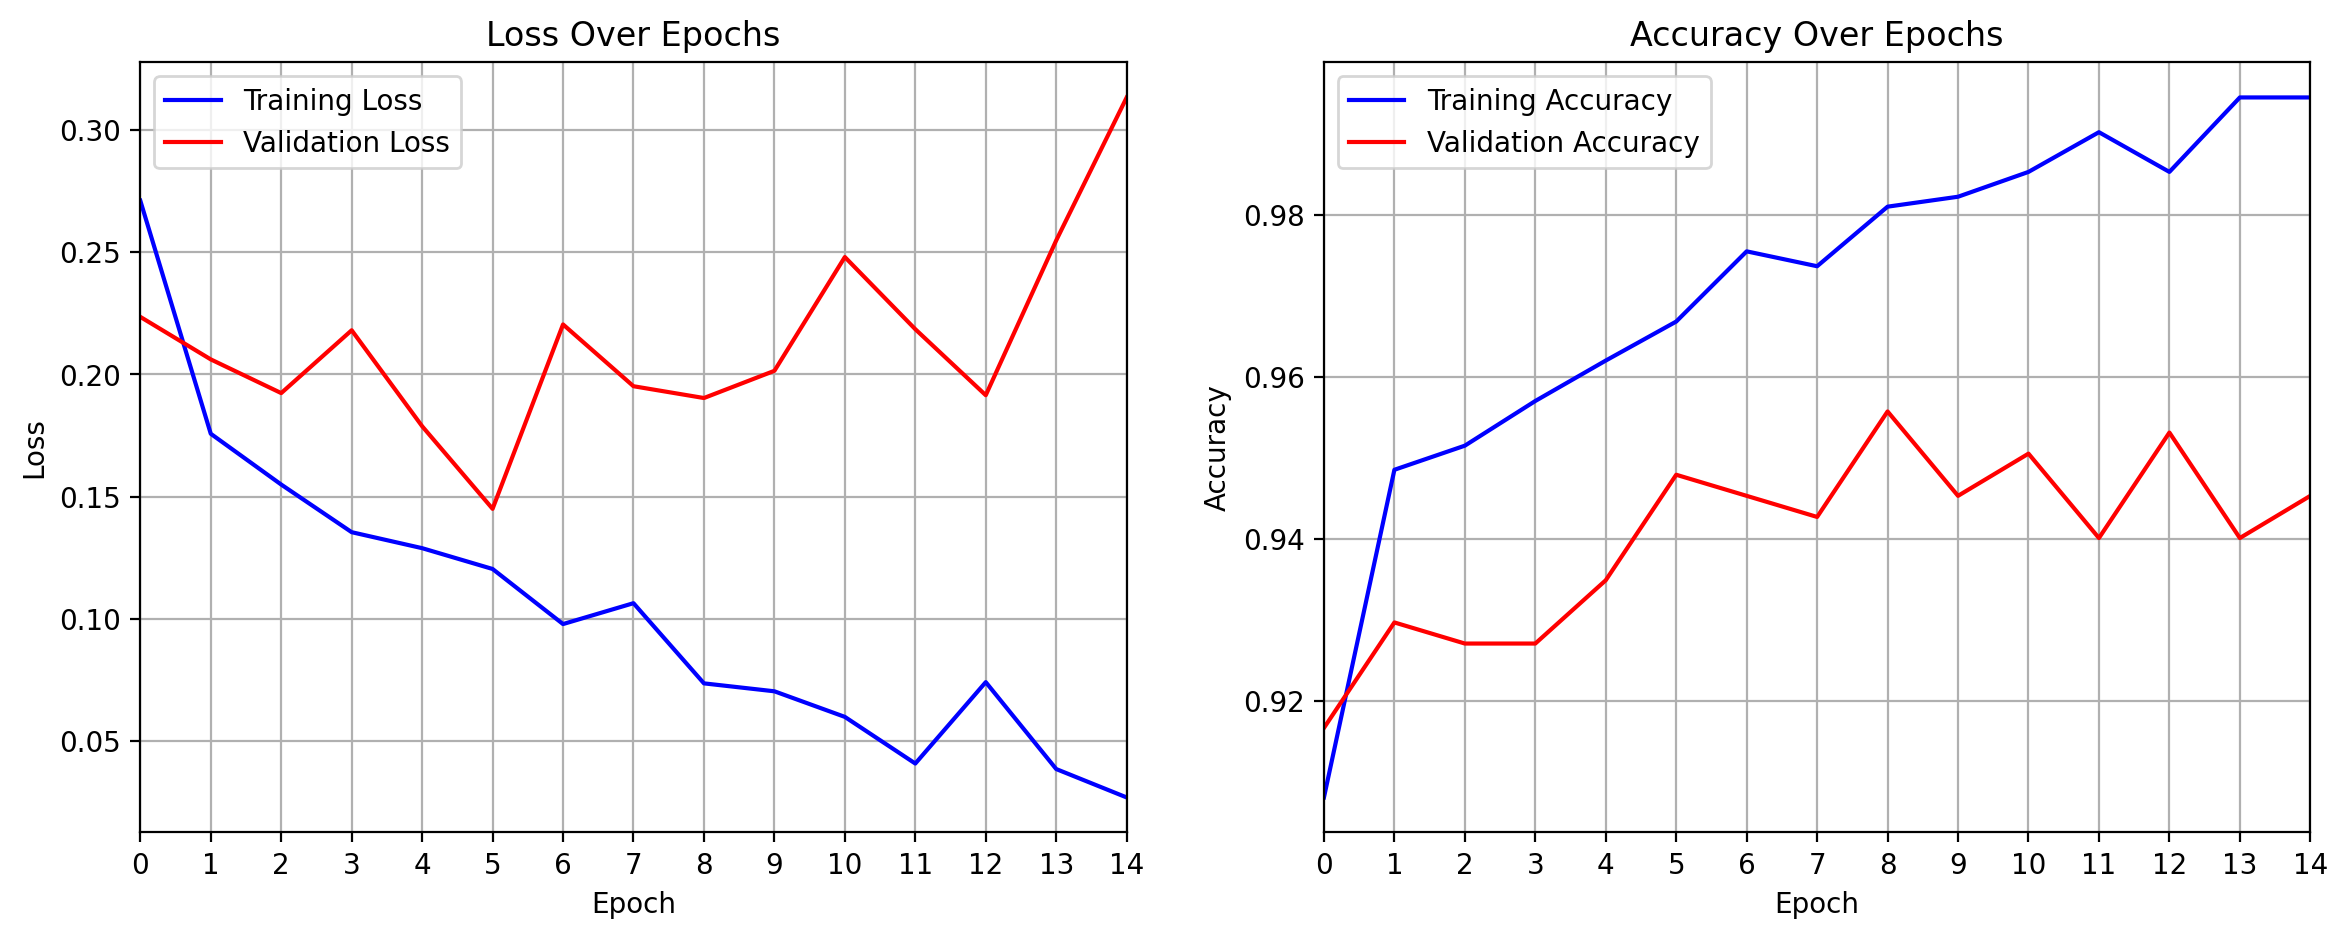

In [50]:
plot_loss_acc(train_losses, validation_losses,train_accuracy,validation_accuracy)

We can see that with the current parameters the model starts overfitting after epoch 5, as the validation loss starts increasing and the training loss continues to decrease.

Similarly the Training Accuracy keeps increasing and the Validation Accuracy plateaus around 0.94.

# Conclusions

We managed to train a simple model (LeNet5) on two datasets
- CIFAR10
- `02_forest_fire_dataset`

For now we've only seen overfitting for the latter dataset after epoch 5.

In a separate notebook, we'll try to repeat the training for LeNet5 using the same hyperparameters as the [authors](https://doi.org/10.1155/2022/5358359) of the paper we're basing the model. Additionally, we need to review the metrics used for evaluation of the model.

# Next Steps

1. Abstract traning loop for an arbitrary model, loss function, and optimizer.
2. Train with same hyperparameters as paper: learning rate, batch size, optimizer, etc.
3. Figure out how to do transfer learning with VGG19 to reproduce paper results.
4. Further define model evaluation metrics (confusion matrix, precision, recall, etc.).
5. Implement `.to(device)` in order to speed up calculations.